In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18
from torchvision.models.feature_extraction import create_feature_extractor
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler





In [53]:
moons_data = datasets.make_moons(n_samples=100000, noise=0.2, random_state=42)

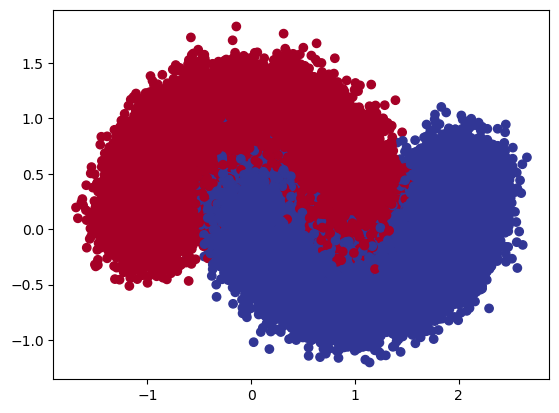

In [54]:
import matplotlib.pyplot as plt

X, y = moons_data

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

In [55]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)


class BinaryClassificationModel(nn.Module):
    def __init__(self,n_inputs,hidden_state,n_outputs,n_layers):
        super(BinaryClassificationModel, self).__init__()
        self.n_layers=n_layers
        self.n_inputs=n_inputs
        self.hidden_state=hidden_state
        self.n_outputs=n_outputs
        model_dictionary={f"fc_{i}":nn.Linear(hidden_state if i!=0 else n_inputs,hidden_state if i!=n_layers-1 else n_outputs) for i in range(n_layers)}
        model_dictionary["sigmoid"]=nn.Sigmoid()
        model_dictionary["relu"]=nn.ReLU()  
        self.model=nn.ModuleDict(model_dictionary)
        
    def forward(self,x):
        for i in range(self.n_layers-1):
            x=self.model[f"fc_{i}"](x)
            x=self.model[f"relu"](x)
        x=self.model[f"fc_{self.n_layers-1}"](x)
        x=self.model[f"sigmoid"](x)
        return x
        
        
        
        

In [56]:
model=BinaryClassificationModel(n_inputs=2,hidden_state=512,n_outputs=1,n_layers=10)

device=torch.device("mps")
model.to(device)



BinaryClassificationModel(
  (model): ModuleDict(
    (fc_0): Linear(in_features=2, out_features=512, bias=True)
    (fc_1): Linear(in_features=512, out_features=512, bias=True)
    (fc_2): Linear(in_features=512, out_features=512, bias=True)
    (fc_3): Linear(in_features=512, out_features=512, bias=True)
    (fc_4): Linear(in_features=512, out_features=512, bias=True)
    (fc_5): Linear(in_features=512, out_features=512, bias=True)
    (fc_6): Linear(in_features=512, out_features=512, bias=True)
    (fc_7): Linear(in_features=512, out_features=512, bias=True)
    (fc_8): Linear(in_features=512, out_features=512, bias=True)
    (fc_9): Linear(in_features=512, out_features=1, bias=True)
    (sigmoid): Sigmoid()
    (relu): ReLU()
  )
)

In [58]:

epochs=1000
optimizer=optim.Adam(model.parameters(),lr=0.001)
criterion=nn.BCELoss()
x_train,y_train=x_train.to(device),y_train.to(device)

for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred=model(x_train)
    y_pred=y_pred.squeeze()
    loss=criterion(y_pred,y_train)
    loss.backward()
    optimizer.step()
    if epoch%100==0:
        print(f"Epoch {epoch}, Loss {loss.item()}")

Epoch 0, Loss 0.6246262788772583
Epoch 100, Loss 0.0784861147403717
Epoch 200, Loss 0.07747293263673782
Epoch 300, Loss 0.07716640830039978
Epoch 400, Loss 0.07689791917800903
Epoch 500, Loss 0.07669571042060852
Epoch 600, Loss 0.07654709368944168
Epoch 700, Loss 0.07629720866680145
Epoch 800, Loss 0.07715518027544022
Epoch 900, Loss 0.07611030340194702


In [ ]:
import torchmetrics
from torchmetrics.classification import BinaryAccuracy

accuracy=BinaryAccuracy(threshold=0.5).to("cpu")

y_test=torch.tensor(y_test,dtype=torch.float32).to("cpu")

with torch.no_grad():
    y_pred=model(x_test.to(device))
    y_pred=y_pred.squeeze()
    accuracy(y_pred.cpu(),y_test)
    

print(f"Accuracy: {accuracy.compute()}")

Accuracy: 0.9750000238418579


/var/folders/p8/93vsd8lj4sx0j8xxdgwj_gmr0000gn/T/ipykernel_15170/3153371843.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test=torch.tensor(y_test,dtype=torch.float32).to("cpu")
